### This File serves as a guide to blinkit's ability in parsing our blink data files and segmenting blinks

In [2]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

import settings
from blinkit import io
from blinkit import data as data
from blinkit import blink_params

import scipy.signal as signal

In [3]:
current_filename = "Device_1_Volts.xls"
dir = ['Chandrika_Yadav', 'ST']
file_path = f"{settings.PATH_TO_DATA}/21-06-22/{dir[1]}/{current_filename}"

In [4]:
df_eog = io.read_Voltsxls(file_path)

In [5]:
use_data = df_eog["CH1"]
use_data = list(use_data[6000:30000])

In [6]:
cutoff=0.05
b, a = signal.butter(2, cutoff, btype='lowpass') #low pass filter
filtered_data= signal.filtfilt(b, a, use_data)

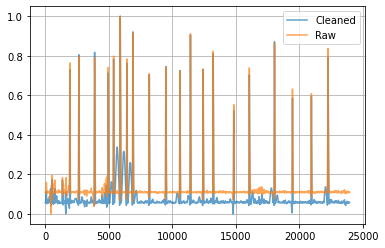

In [7]:
eog_cleaned = nk.eog_clean(filtered_data, sampling_rate=100, method='neurokit')
plt.plot(data.detrend_standardize( eog_cleaned), alpha =0.7, label = "Cleaned")
plt.plot(data.detrend_standardize( filtered_data), alpha =0.7, label = "Raw")
plt.legend()
plt.grid()

In [11]:
blinks = nk.signal_findpeaks(eog_cleaned, relative_height_min=0)
print(f"{len(blinks['Peaks'])} Blinks found")
df_blinks = pd.DataFrame(blinks)

41 Blinks found


In [12]:
blink_params.blink_stats.perform(eog_cleaned, df_blinks)

In [13]:
df_blinks

,Peaks,Distance,Height,Width,Onsets,Offsets,0width,0.2width,0.5width,0.95width,spmax_close,spmin_open,blink_interval,moment1,moment2,moment3,moment4
0,281,285.0,0.000135,235.070728,194,385,439.805591,410.179627,235.070728,41.802258,19,171,133,0.0,4.714057e-10,-1.300828e-14,8.171401e-19
1,547,266.0,0.000207,190.225105,518,626,1428.645228,309.868251,190.225105,11.785840,16,39,543,0.0,1.251994e-09,1.044270e-14,3.677503e-18
2,1345,798.0,0.000159,119.299726,1169,1390,580.419120,551.049728,119.299726,14.751650,164,196,224,0.0,1.897035e-09,-4.154046e-14,1.166916e-17
3,1647,302.0,0.000192,99.048044,1614,1737,500.831337,391.792942,99.048044,14.069841,18,43,159,0.0,1.211659e-09,-1.602879e-15,2.729329e-18
4,1934,285.0,0.000664,32.764308,1896,1990,2104.056912,50.811141,32.764308,8.732740,24,51,21,0.0,5.325324e-08,6.873776e-12,5.066981e-15
5,2303,369.0,0.000112,393.771137,2011,2347,553.933045,468.172561,393.771137,113.527481,46,323,256,0.0,1.230130e-09,-3.749868e-14,3.691546e-18
6,2642,285.0,0.000743,35.916519,2603,2710,1215.322748,57.431756,35.916519,9.597281,24,53,764,0.0,6.166625e-08,9.851037e-12,7.228807e-15
7,3619,977.0,0.000147,883.941548,3474,3838,1066.439164,984.074128,883.941548,26.733427,52,354,0,0.0,3.927884e-09,-2.412222e-13,4.558024e-17
8,3879,260.0,0.000763,43.774962,3838,3964,1982.901100,76.035109,43.774962,11.113066,25,57,0,0.0,5.918262e-08,8.590811e-12,6.755661e-15
9,4233,283.0,0.000096,264.818788,3964,4449,416.448364,354.300613,264.818788,35.121606,28,455,240,0.0,1.523550e-09,-3.777798e-14,5.656818e-18


Text(0.5, 0.98, 'A single blink')

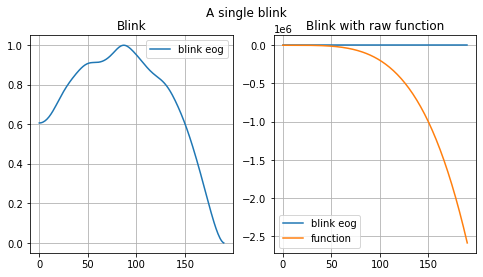

In [20]:
from blinkit import blink_fit

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
curr_blink = df_blinks.iloc[0]
blink_range = eog_cleaned[int(curr_blink["Onsets"]): int(curr_blink["Offsets"])]
norm_data = data.normalize(blink_range)
ax[0].plot(norm_data, label = "blink eog")
ax[0].set_title("Blink")
ax[0].grid()
ax[0].legend()

x = range(len(norm_data))
p0 = [0.0005, 0.003, -0.002, 0.0005, 0]
temp_func = blink_fit.fitfunc_wrapper(blink_fit.paper_func.func, p0)
ax[1].plot(norm_data, label = "blink eog")
ax[1].plot(temp_func(x), label = "function")
ax[1].legend()
ax[1].grid()
ax[1].set_title("Blink with raw function")
plt.suptitle("A single blink")

In [21]:
import scipy
popt, pcov = scipy.optimize.curve_fit(blink_fit.paper_func.func, x, norm_data, p0 = p0)
temp_func = blink_fit.fitfunc_wrapper(blink_fit.paper_func.func, popt)

c:\users\vishn\documents\workspace\blink_research\blinks_main\blinkit\blinkit\blink_fit.py:42: RuntimeWarning: divide by zero encountered in power
  return (a0 * np.power(x, 2)) + (a1 * np.power(x, 3)) + (a2 * np.power(x, 4)) + np.exp(-b * np.power(x, c))


c:\users\vishn\documents\workspace\blink_research\blinks_main\blinkit\blinkit\blink_fit.py:42: RuntimeWarning: divide by zero encountered in power
  return (a0 * np.power(x, 2)) + (a1 * np.power(x, 3)) + (a2 * np.power(x, 4)) + np.exp(-b * np.power(x, c))


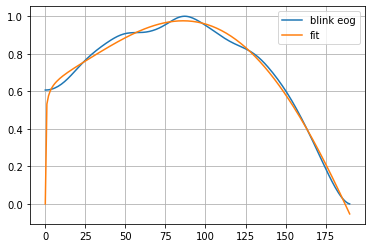

In [22]:
plt.plot(norm_data, label = "blink eog")
plt.plot(temp_func(x), label = "fit")
plt.legend()
plt.grid()

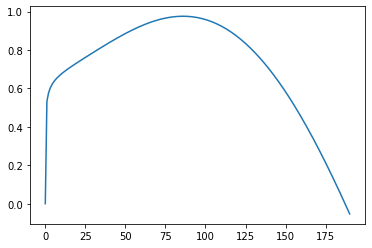

In [23]:
popt, pcov, x, y = blink_fit.lsqr_fit(norm_data, blink_fit.paper_func, p0, sampling_rate = 1, centering = False)
plt.plot(x, y)
## Need to finetune the above function so it can fit
#functionality for sampling rate and centering so that blink fits can
#  easily be superimposed on each other